In [1]:
#Reading Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import matplotlib.pyplot as plt, gc, os
from matplotlib import patches
import seaborn as sns
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Amex Metric
def xgb_amex(y_pred, y_true):
    return 'amex', amex_metric_np(y_pred,y_true.get_label())

def amex_metric_np(preds: np.ndarray, target: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / np.sum(target)

    weighted_target = target * weight
    lorentz = (weighted_target / weighted_target.sum()).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    gini_max = 10 * n_neg * (n_pos + 20 * n_neg - 19) / (n_pos + 20 * n_neg)

    g = gini / gini_max
    return 0.5 * (g + d)

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [20]:
###
def remove_missing_val(df, threshold = 0.5):
    missing_props = df.isna().mean(axis=0)
    drop_features = missing_props[missing_props>=threshold].index
    print(drop_features)
    df.drop(drop_features, axis = 1, inplace = True)
    return df
###
def get_not_used():
    # cid is the label encode of customer_ID
    # row_id indicates the order of rows
    return ['row_id', 'customer_ID', 'target', 'cid', 'S_2']
    
def preprocess(df):
    df['row_id'] = np.arange(df.shape[0])
    not_used = get_not_used()
    cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',
                'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    
    op1 = ['P_2']+['B_'+ f'{num}' for num in [12, 13, 18, 2, 33, 42]] + ['D_'+ f'{num}' for num in [106, 49, 71, 77, 47]]
    op2 = ['B_'+ f'{num}' for num in [1, 7, 11, 23, 37, 4, 16]] + ['D_55', 'D_48']
    
    for col in df.columns:
        if col not in not_used+cat_cols:
            df[col] = df[col].round(2)

    # compute "after pay" features
    for bcol in [f'B_{i}' for i in [11,14,17]]+['D_39','D_131']+[f'S_{i}' for i in [16,23]]:
        for pcol in ['P_2','P_3']:
            if bcol in df.columns:
                df[f'{bcol}-{pcol}'] = df[bcol] - df[pcol]
    
    ###added
    for c1 in op1:
        for c2 in op2:
            if f'{c2}-{c1}' not in df.columns:
                df[f'{c2}-{c1}'] = df[c2] - df[c1]
    ###

    df['S_2'] = pd.to_datetime(df['S_2'])
    df['cid'], _ = df.customer_ID.factorize()
        
    num_cols = [col for col in df.columns if col not in cat_cols+not_used]
    
    dgs = add_stats_step(df, num_cols)
        
    df = df.sort_values('row_id')
    df = df.drop(['row_id'],axis=1)
    return df, dgs

def add_stats_step(df, cols):
    n = 50
    dgs = []
    for i in range(0,len(cols),n):
        s = i
        e = min(s+n, len(cols))
        dg = add_stats_one_shot(df, cols[s:e])
        dgs.append(dg)
    return dgs

def add_stats_one_shot(df, cols):
    stats = ['mean','std']
    dg = df.groupby('customer_ID').agg({col:stats for col in cols})
    out_cols = []
    for col in cols:
        out_cols.extend([f'{col}_{s}' for s in stats])
    dg.columns = out_cols
    dg = dg.reset_index()
    return dg

def load_test_iter(features, chunks=4):
    
    test_rows = 11363762
    chunk_rows = test_rows // chunks
    
    test = pd.read_parquet(f'test.parquet',
                             columns=['customer_ID','S_2'])

    ###modified
    test = test.iloc[:test_rows]
    
    test = get_segment(test)
    start = 0
    while start < test.shape[0]:
        if start+chunk_rows < test.shape[0]:
            end = test['cus_count'].values[start+chunk_rows]
        else:
            end = test['cus_count'].values[-1]
        end = int(end)
        df = pd.read_parquet(f'test.parquet')

        ###modified
        df = df.iloc[start:end]
        
        
        start = end
        yield process_test_data(df, features)

### new method
def load_test():
    test = pd.read_parquet(f'train.parquet')
    return process_data(test)
###

def load_train():
    train = pd.read_parquet(f'train.parquet')
    train, features = process_data(train)
    trainl = pd.read_csv(f'train_labels.csv')
    train = train.merge(trainl, on='customer_ID', how='left')
    return train, features

def process_data(df):
    df,dgs = preprocess(df)
    ##
    df = remove_missing_val(df)
    ##
    df = df.drop_duplicates('customer_ID',keep='last')
    for dg in dgs:
        df = df.merge(dg, on='customer_ID', how='left')
    diff_cols = [col for col in df.columns if col.endswith('_diff')]
    df = df.drop(diff_cols,axis=1)
    return df, df.columns

def process_test_data(df, features):
    df,dgs = preprocess(df)
    df = df.drop_duplicates('customer_ID',keep='last')
    for dg in dgs:
        df = df.merge(dg, on='customer_ID', how='left')
    diff_cols = [col for col in df.columns if col.endswith('_diff')]    
    df = df.drop(diff_cols,axis=1)
    ##
    drop_cols = [col for col in df.columns if col not in features]
    df = df.drop(drop_cols, axis = 1)
    ##
    return df


def get_segment(test):
    dg = test.groupby('customer_ID').agg({'S_2':'count'})
    dg.columns = ['cus_count']
    dg = dg.reset_index()
    dg['cid'],_ = dg['customer_ID'].factorize()
    dg = dg.sort_values('cid')
    dg['cus_count'] = dg['cus_count'].cumsum()
    
    test = test.merge(dg, on='customer_ID', how='left')
    test = test.sort_values(['cid','S_2'])
    assert test['cus_count'].values[-1] == test.shape[0]
    return test

In [19]:
#XGBOOST Model
def xgb_train(x, y, xt, yt):
    print("# of features:", x.shape[1])
    assert x.shape[1] == xt.shape[1]
    dtrain = xgb.DMatrix(data=x, label=y)
    dvalid = xgb.DMatrix(data=xt, label=yt)
    params = {
            'objective': 'binary:logistic', 
            'tree_method': 'hist', 
            'max_depth': 7,
            'subsample':0.88,
            'colsample_bytree': 0.5,
            'gamma':1.5,
            'min_child_weight':8,
            'lambda':70,
            'eta':0.03,
    }
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    bst = xgb.train(params, dtrain=dtrain,
                num_boost_round=2600,evals=watchlist,
                early_stopping_rounds=500, feval=xgb_amex, maximize=True,
                verbose_eval=100)
    print('best ntree_limit:', bst.best_ntree_limit)
    print('best score:', bst.best_score)
    return bst.predict(dvalid, iteration_range=(0,bst.best_ntree_limit)), bst

In [15]:
#Load Train Data
train, features = load_train()

Index(['D_42', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_73', 'D_76', 'B_29',
       'D_88', 'D_105', 'D_110', 'B_39', 'B_42', 'D_132', 'D_134', 'D_142',
       'B_17-P_2', 'B_17-P_3', 'B_1-B_42', 'B_7-B_42', 'B_11-B_42',
       'B_23-B_42', 'B_37-B_42', 'B_4-B_42', 'B_16-B_42', 'D_55-B_42',
       'D_48-B_42'],
      dtype='object')


In [16]:
features

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'B_37-D_47_mean', 'B_37-D_47_std', 'B_4-D_47_mean', 'B_4-D_47_std',
       'B_16-D_47_mean', 'B_16-D_47_std', 'D_55-D_47_mean', 'D_55-D_47_std',
       'D_48-D_47_mean', 'D_48-D_47_std'],
      dtype='object', length=880)

In [6]:
#XGBoost Parameters
folds = 4
seed = 42
xgb_param = {
            'objective': 'binary:logistic', 
            'tree_method': 'hist', 
            'max_depth': 7,
            'subsample':0.88,
            'colsample_bytree': 0.5,
            'gamma':1.5,
            'min_child_weight':8,
            'lambda':70,
            'eta':0.03,
            'random_state':seed
}

In [7]:
%%time
importance = []
not_used = get_not_used()
not_used = [i for i in not_used if i in train.columns]
train_x, train_y = train.drop(not_used, axis=1), train['target']
score = 0

skf = KFold(n_splits = folds, shuffle = True, random_state = seed)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_x, train_y)):
    print("=============")
    print("Fold", fold+1)
    print("# of features:", train_x.shape[1])
    X_train = train_x.loc[train_idx]
    y_train = train_y.loc[train_idx]
    X_valid = train_x.loc[valid_idx]
    y_valid = train_y.loc[valid_idx]
    
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dvalid = xgb.DMatrix(X_valid, label = y_valid)
    model = xgb.train(xgb_param,
                      dtrain = dtrain,
                      evals =[(dtrain, 'train'), (dvalid, 'valid')],
                      num_boost_round = 9000,
                      early_stopping_rounds = 500,
                      feval=xgb_amex, maximize=True,
                      verbose_eval = 100
                      )
    
    
    
    model.save_model(f'xgb_{fold}.json')
    model_sc = model.get_score(importance_type='weight')
    df_sc = pd.DataFrame({'feature':model_sc.keys(),f'importance_{fold}':model_sc.values()})
    importance.append(df_sc)
    
    preds = model.predict(dvalid)
    amex_score = amex_metric(pd.DataFrame({'target':y_valid.values.copy()}), 
                                    pd.DataFrame({'prediction':preds}))
    msg = f"Fold {fold+1} amex {amex_score:.4f}"
    print(msg)
    score += amex_score
score /= folds
print(f"Average amex score: {score:.4f}")

Fold 1
# of features: 877
[0]	train-logloss:0.67373	train-amex:0.70941	valid-logloss:0.67386	valid-amex:0.69641
[100]	train-logloss:0.24071	train-amex:0.78391	valid-logloss:0.24861	valid-amex:0.76823
[200]	train-logloss:0.21648	train-amex:0.79931	valid-logloss:0.22905	valid-amex:0.77843
[300]	train-logloss:0.20790	train-amex:0.81091	valid-logloss:0.22474	valid-amex:0.78450
[400]	train-logloss:0.20218	train-amex:0.81975	valid-logloss:0.22266	valid-amex:0.78676
[500]	train-logloss:0.19753	train-amex:0.82718	valid-logloss:0.22138	valid-amex:0.78845
[600]	train-logloss:0.19334	train-amex:0.83419	valid-logloss:0.22058	valid-amex:0.79023
[700]	train-logloss:0.18945	train-amex:0.84131	valid-logloss:0.21993	valid-amex:0.79131
[800]	train-logloss:0.18610	train-amex:0.84707	valid-logloss:0.21955	valid-amex:0.79160
[900]	train-logloss:0.18278	train-amex:0.85283	valid-logloss:0.21930	valid-amex:0.79195
[1000]	train-logloss:0.17961	train-amex:0.85814	valid-logloss:0.21908	valid-amex:0.79162
[1100]	

In [10]:
VER = 3

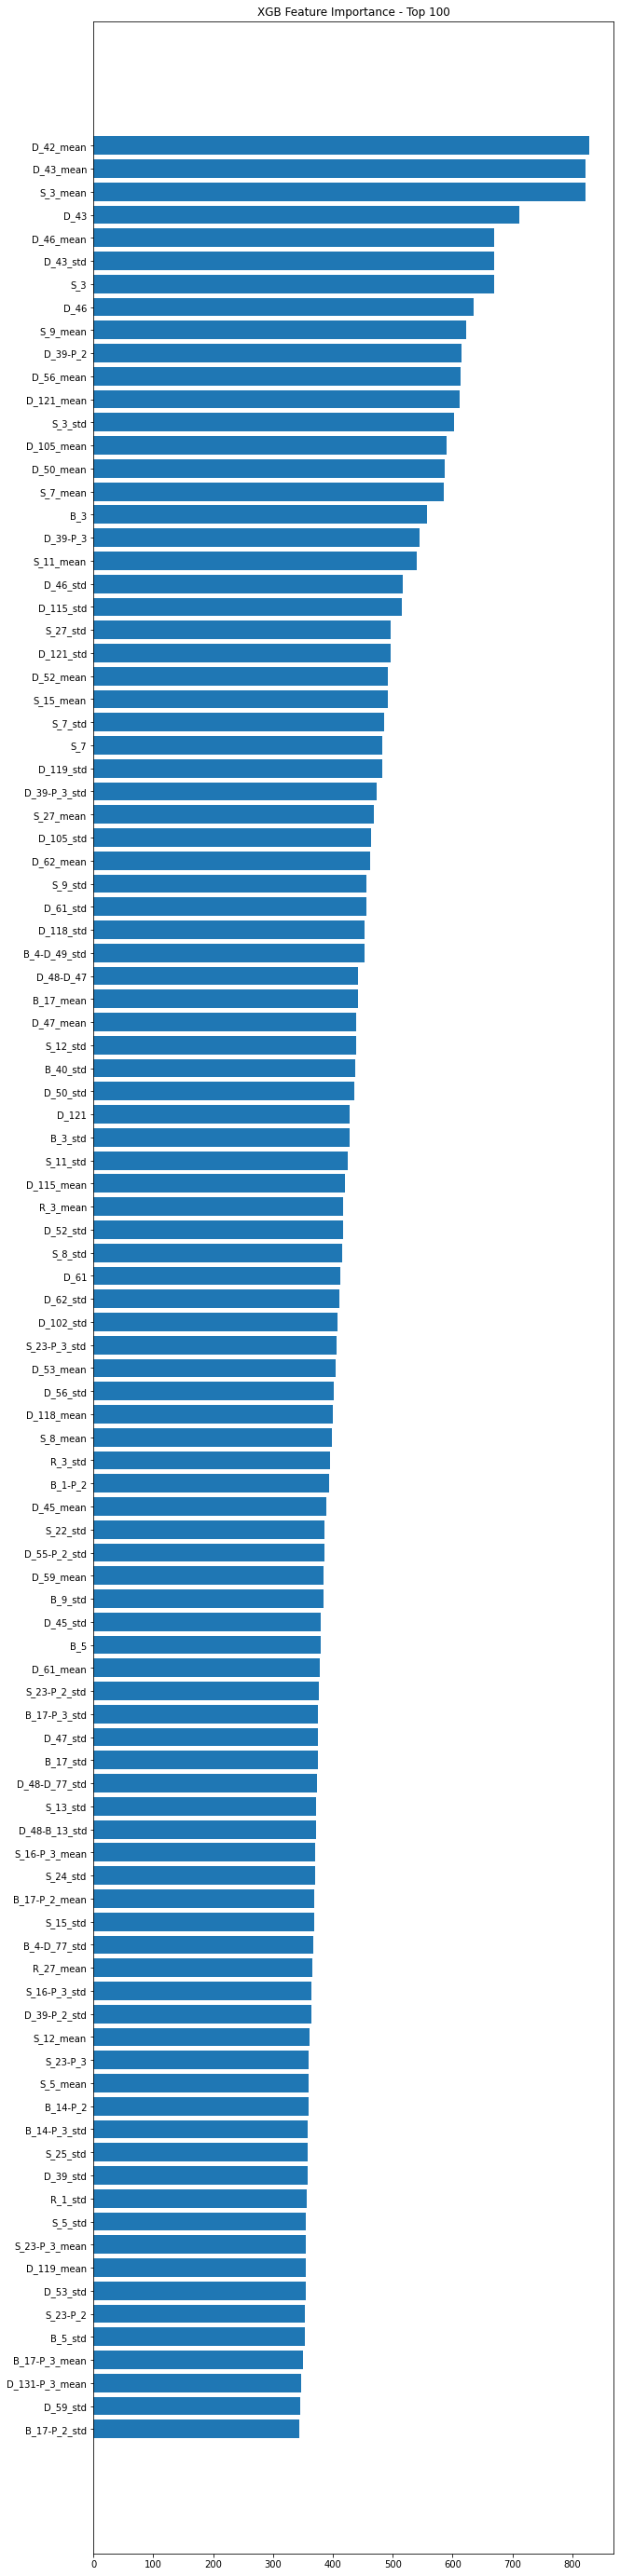

In [11]:
#Feature Importance
df_imp = importance[0].copy()
for i in range(1, folds):
    df_imp = df_imp.merge(importance[i], on='feature', how = 'left')
df_imp['importance'] = df_imp.iloc[:,1:].mean(axis=1)
df_imp = df_imp.sort_values('importance', ascending = False)
df_imp.to_csv(f'feature_importance/xgb_feature_importance_v{VER}.csv',index=False)

NUM_FEATURES = 100
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df_imp.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df_imp.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

In [22]:
%%time

#Predict on Test Data
cids = []
yps = []
chunks = 4
for df in tqdm(load_test_iter(features, chunks),total=chunks):
    cids.append(df['customer_ID'])
    not_used = [i for i in not_used if i in df.columns]

    yp = 0
    for i in range(folds):
        bst = xgb.Booster()
        bst.load_model(f'xgb_{i}.json')
        dx = xgb.DMatrix(df.drop(not_used, axis=1))
        print('best ntree_limit:', bst.best_ntree_limit)
        yp += bst.predict(dx, iteration_range=(0,bst.best_ntree_limit))
    yps.append(yp/folds)
    
df = pd.DataFrame()
df['customer_ID'] = pd.concat(cids)
df['prediction'] = np.concatenate(yps)
df.head()

  0%|                                                     | 0/4 [00:00<?, ?it/s]

best ntree_limit: 1529
best ntree_limit: 1446
best ntree_limit: 1334
best ntree_limit: 2010


 25%|███████████▎                                 | 1/4 [00:53<02:39, 53.22s/it]

best ntree_limit: 1529
best ntree_limit: 1446
best ntree_limit: 1334
best ntree_limit: 2010


 50%|██████████████████████▌                      | 2/4 [01:42<01:42, 51.09s/it]

best ntree_limit: 1529
best ntree_limit: 1446
best ntree_limit: 1334
best ntree_limit: 2010


 75%|█████████████████████████████████▊           | 3/4 [02:32<00:50, 50.32s/it]

best ntree_limit: 1529
best ntree_limit: 1446
best ntree_limit: 1334
best ntree_limit: 2010


100%|█████████████████████████████████████████████| 4/4 [03:22<00:00, 50.57s/it]

CPU times: user 7min 5s, sys: 1min 31s, total: 8min 37s
Wall time: 3min 22s


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.021757
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000696
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.059774
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.238572
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.840846


In [23]:
#prepare for submission
df.to_csv('amex_submission.csv',index=False)